# 獲得ユーザーの質に差がある？

- 「仕事ではじめる機械学習」(オライリー・ジャパン発行 ISBN978-4-87311-825-3)
- p119- 8章 効果検証 9.3節 Uplift Modeling

In [1]:
# ライブラリの読み込み
import random
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## サンプルデータの生成

In [2]:
def generate_sample_data(num, seed=1):

  # 統制群と実験群の特徴力の基準値を定義する
  base_weight = np.array([0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00])
  lift_weight = np.array([0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00])
  lifted_weight = base_weight + lift_weight
  weight_len = len(base_weight)

  # 返却するリストを確保。ここにデータを投入していく
  df = pd.DataFrame(columns=["is_cv", "is_treat", "feature_vector"])

  # 乱数を初期化
  rnd = random.Random(seed)
  np.random.seed(seed)

  for i in range(num):

    # 特徴ベクトルを乱数で発生させる
    feature_vector = np.random.rand(weight_len)

    # 実験群かどうかを乱数で決定する
    is_treat = rnd.choice((True, False))

    # コンバージョンレートを算出する
    if is_treat: # 実験群
      cv_rate = (feature_vector * lifted_weight).sum()
    else: # 統制群
      cv_rate = (feature_vector * base_weight).sum()

    # レートを加味しつつ乱数を用いて実際にコンバージョンしたかどうかを決定する
    is_cv = cv_rate > rnd.random()

    df = df.append({"is_treat": is_treat, "is_cv": is_cv, "feature_vector": feature_vector}, ignore_index=True)
    
  return df

In [3]:
%%time
df = generate_sample_data(50000, 123)

CPU times: user 9min 43s, sys: 13 s, total: 9min 56s
Wall time: 10min 26s


# コンバージョンレートを確認

In [4]:
def get_cvr(df):
    df_treat = df[df["is_treat"] == True]
    uu_treat = len(df_treat)
    cv_treat = list(df_treat["is_cv"]).count(True)
    cvr_treat = cv_treat / uu_treat
    
    df_control = df[df["is_treat"] == False]
    uu_control = len(df_control)
    cv_control = list(df_control["is_cv"]).count(True)
    cvr_control = cv_control / uu_control
    
    return [cvr_treat, cvr_control]

print(get_cvr(df))

[0.03102577464224155, 0.032930188001436954]


## 予測モデルを構築

In [5]:
def get_model(df):
    X = list(df['feature_vector']) # 説明変数
    y = list(df['is_cv']) # 目的変数
    lr = LogisticRegression(C=0.01) # ロジスティック回帰によるクラス分類
    lr.fit(X, y) # 学習を実行
    return lr

mdl_treat = get_model(df[df["is_treat"] == True])
mdl_control = get_model(df[df["is_treat"] == False])

## 別のテストデータでUMスコアを算出する

In [6]:
%%time
# ランダムシードを変えて新たなテストデータを生成
df2 = generate_sample_data(50000, 456)

CPU times: user 9min 2s, sys: 11.4 s, total: 9min 13s
Wall time: 9min 22s


In [7]:
# ２つの学習器でコンバージョンレートを予測
df2["score_treat"] = mdl_treat.predict_proba(list(df2['feature_vector']))[:, 1]
df2["score_control"] = mdl_control.predict_proba(list(df2['feature_vector']))[:, 1]

In [8]:
# UpliftModelingのスコア = 実験群の予測値 / 統制群の予測値
df2["score"] = df2["score_treat"] / df2["score_control"] 

In [9]:
# スコアが高い順にならべかえる
df2 = df2.sort_values('score', ascending=False)
# インデックスも割り振り直す
df2 = df2.reset_index(drop=True)

# スコアごとのCVRを確認
スコアが高い部分では統制群のコンバージョンレートが高く実験群のコンバージョンレートが低い
スコアが低い部分では統制群のコンバージョンレートが低く実験群のコンバージョンレートが高い
という傾向が見られればUplift Modelingが正しく機能していると言える。

In [10]:
# 10パーセンタイルごとに計算する
qdf = pd.DataFrame(columns=('cvr_treat', 'cvr_control'))
for n in range(10):
    p = len(df2) / 10
    s = int(n * p)
    e = int((n + 1) * p - 1)    
    qdf.loc[n] = get_cvr(df2[s:e])

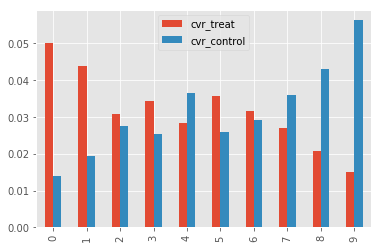

In [11]:
# 描画
qdf.plot.bar()

# AUUCで評価する
Area Under the Uplift Curve

In [12]:
# 結果を格納する変数を初期化
s = pd.Series({
    "score": 0.0,
    "uu_treat": 0, "cv_treat": 0, "cvr_treat": 0.0,
    "uu_control": 0, "cv_control": 0, "cvr_control": 0.0,
    "lift": 0.0
})
stat = pd.DataFrame(columns=s.index)

In [13]:
%%time
# スコアが高い順に計算する
for i, row in df2.iterrows():
    s["score"] = row["score"]
    if row['is_treat']:
        s["uu_treat"] += 1
        if row["is_cv"]:
            s["cv_treat"] += 1
        s["cvr_treat"] = s["cv_treat"] / s["uu_treat"]
    else:
        s["uu_control"] += 1
        if row["is_cv"]:
            s["cv_control"] += 1
        s["cvr_control"] = s["cv_control"] / s["uu_control"]
    
    # コンバージョンレートに実験群の人数を数えることでliftを算出する
    # CVRの差なので、実験群と統制群の人数が異なっていても算出が可能
    s["lift"] = (s["cvr_treat"] - s["cvr_control"]) * s["uu_treat"]
    stat = stat.append(s.copy(), ignore_index=True)

# lambda関数化してDataFrame.apply()を使うと高速になる知れないけど可読性が落ちる
# generate_sample_data()がnotebook全体のボトルネックなのでここは後回し

CPU times: user 1min 22s, sys: 10.7 s, total: 1min 32s
Wall time: 1min 35s


In [14]:
# liftのベースラインを計算する
p = stat["lift"][len(stat) - 1] /  len(stat)
stat["lift_base_line"] = stat.apply(lambda x: (p * x.name), axis=1)

In [15]:
# AUUCを算出する
auuc = (stat["lift"] - stat["lift_base_line"]).sum() / len(stat)
print("AUUC:", auuc)

AUUC: 135.17705080922


Text(0,0.5,'conversion count')

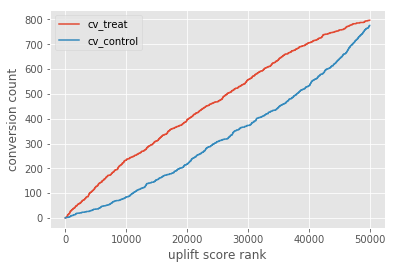

In [16]:
# 描画：実験群と統制群のコンバージョン数の差
stat.plot(y=["cv_treat", "cv_control"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion count")

(0.0, 0.06)

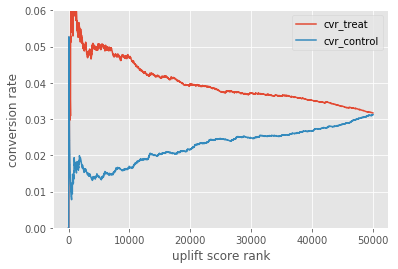

In [17]:
# 描画：実験群と統制群のコンバージョンレートの差
stat.plot(y=["cvr_treat", "cvr_control"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")
plt.ylim(0.00, 0.06)

Text(0,0.5,'conversion lift')

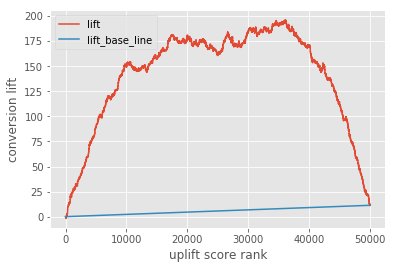

In [18]:
# 描画：コンバージョンレートの差から計算した推定コンバージョン上昇件数
stat.plot(y=["lift", "lift_base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion lift")

Text(0,0.5,'conversion lift')

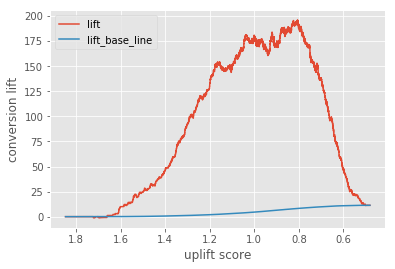

In [19]:
# 描画：横軸をスコアにした推定コンバージョン上昇件数
stat.plot(x="score", y=["lift", "lift_base_line"])
plt.gca().invert_xaxis()
plt.xlabel("uplift score")
plt.ylabel("conversion lift")

Text(0,0.5,'user count')

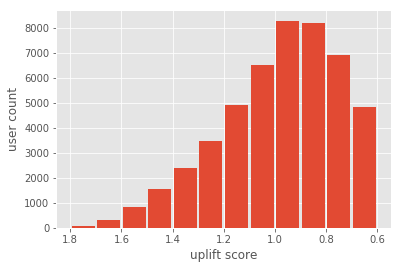

In [20]:
# 描画：スコアごとの人数
stat['score'].hist(histtype="bar", rwidth=0.9, range=(0.6, 1.8), bins=12, align="mid")
plt.gca().invert_xaxis()
plt.xlabel("uplift score")
plt.ylabel("user count")

Uplift Modelingの精度が高い場合、スコア上位では実験群でCVし統計群でCVしない傾向がある。
スコアが1.0以上に対して介入を行うと効果が最大化される。
スコアが1.2以上を対象にすれば、介入コストが大幅に下がるので高い費用対効果が期待できる。